In [2]:
# from google.colab import drive
# drive.mount('/content/drive')
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
print(gpus)
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_virtual_device_configuration(gpu,[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=6000)])

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-04-25 18:10:15.273642: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-25 18:10:15.328992: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-25 18:10:15.329131: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

# **Importing Important Libraries**

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras 
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint,TensorBoard
import pathlib 
from shutil import copyfile
import os 
import PIL
from PIL import Image
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from keras.regularizers import l2

2023-04-25 18:10:10.307204: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-25 18:10:10.411272: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-25 18:10:10.964753: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


**Visualization**

In [3]:
def plot(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0,1.0])
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

# **Loading and Preprocessing Data**

In [4]:
data_dir = pathlib.Path("Training Set")
print(len(list(data_dir.glob("*/*"))))


300


In [ ]:
trash = list(data_dir.glob('Can/*'))
PIL.Image.open(str(trash[0]))

In [5]:
batch_size = 32
image_height = 224
image_width = 224

In [6]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(image_height, image_width),
  batch_size=batch_size)

Found 63306 files belonging to 3 classes.
Using 50645 files for training.


2023-04-25 18:10:37.629240: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-25 18:10:37.629403: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-25 18:10:37.629470: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [112]:
print(type(train_ds))

<class 'tensorflow.python.data.ops.batch_op._BatchDataset'>


In [7]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(image_height, image_width),
  batch_size=batch_size)

Found 63306 files belonging to 3 classes.
Using 12661 files for validation.


In [8]:
# Evaluating on a new dataset from the internet
# paper and plastic from  https://www.kaggle.com/datasets/arthurcen/waste-images-from-sushi-restaurant
# can from https://universe.roboflow.com/dataset-t7hz7/cans-fdboa/dataset/1
test_dir = pathlib.Path("dcrpi-a")


test_ds = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  seed=123,
  image_size=(image_height, image_width),
  batch_size=batch_size)


Found 123 files belonging to 3 classes.


In [ ]:
# Don't run this cell if you are testing on a new dataset
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 2)
val_ds = val_ds.skip(val_batches // 2)

In [9]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_ds))
# print('Number of test batches: %d' % tf.data.experimental.cardinality(test_ds))

Number of validation batches: 146


In [9]:
#Classes as inferred
class_names = train_ds.class_names
print(class_names)

['Can', 'Paper', 'Plastic']


2023-04-22 21:13:17.561860: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [50645]
	 [[{{node Placeholder/_0}}]]
2023-04-22 21:13:17.562254: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [50645]
	 [[{{node Placeholder/_4}}]]


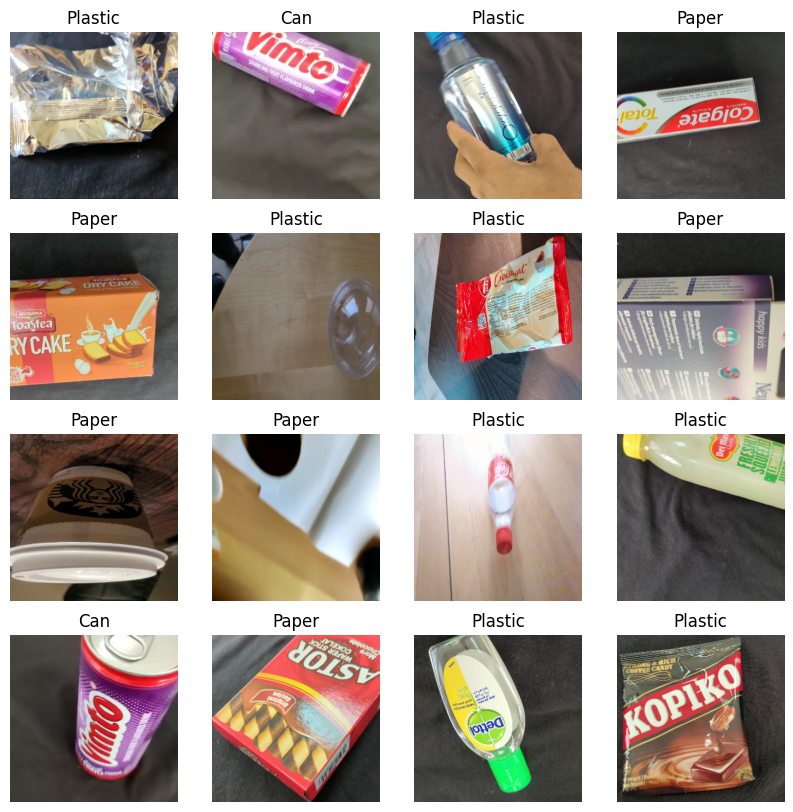

In [116]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [11]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 299, 299, 3)
(32,)


# **Configure Dataset Performance**

In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds= test_ds.prefetch(buffer_size=AUTOTUNE)

# **Data Augmentation**

In [10]:
def image_augmentation(inputs):
    data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomRotation(factor=0.15),
  tf.keras.layers.RandomTranslation(height_factor=0.1,width_factor=0.1),
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomZoom(0.2),
  tf.keras.layers.RandomContrast(factor=0.1)
])(inputs)
    return data_augmentation

In [11]:
def preprocess_image_input(input_images):
    #input_images = input_images.astype('float32')
    output_ims = preprocess_input(input_images)
    return output_ims



In [12]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min')


In [13]:
def feature_extractor(inputs):
    base_model = ResNet50(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=(224,224,3),
    pooling=None,
    classes=1000,
    classifier_activation='softmax'
    )(inputs)
    base_model.trainable = False
    #Don't train existing weights
    return base_model
def classifier(inputs):
    x = layers.MaxPooling2D(2,2)(inputs)
    x = layers.Flatten()(inputs)
    x = layers.Dense(256,activation='relu')(x)
    x = layers.Dense(128,activation='relu')(x)
    x = layers.Dense(3,activation='softmax',name='classification')(x)
    return x 

def final_model(inputs):
    x = image_augmentation(inputs)
    x = preprocess_image_input(inputs)
    x = feature_extractor(x)
    x = classifier(x)
    return x

def compile_model():
    inputs = tf.keras.Input(shape=(224,224,3),name="input")
    classification_outputs = final_model(inputs)
    model = tf.keras.Model(inputs=inputs,outputs=classification_outputs)
    model.compile(optimizer=Adam(1e-3),loss=SparseCategoricalCrossentropy(),metrics=["accuracy"])
    return model

model = compile_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 256)               25690368  
                                                             

In [14]:

history = model.fit(train_ds,validation_data=val_ds,epochs=50,batch_size=32,callbacks=[early_stop])

Epoch 1/50


2023-04-25 18:12:31.883633: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [50645]
	 [[{{node Placeholder/_0}}]]
2023-04-25 18:12:31.883838: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [50645]
	 [[{{node Placeholder/_0}}]]
2023-04-25 18:12:39.876880: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-04-25 18:12:41.771472: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-04-2

1583/1583 [==============================] - ETA: 0s - loss: 0.4095 - accuracy: 0.8841

2023-04-25 18:17:32.460964: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [12661]
	 [[{{node Placeholder/_4}}]]
2023-04-25 18:17:32.461144: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [12661]
	 [[{{node Placeholder/_0}}]]


1583/1583 [==============================] - 330s 193ms/step - loss: 0.4095 - accuracy: 0.8841 - val_loss: 43.9102 - val_accuracy: 0.6850
Epoch 2/50
1583/1583 [==============================] - 304s 192ms/step - loss: 0.1439 - accuracy: 0.9582 - val_loss: 0.1246 - val_accuracy: 0.9641
Epoch 3/50
1583/1583 [==============================] - 305s 193ms/step - loss: 0.0866 - accuracy: 0.9739 - val_loss: 0.7532 - val_accuracy: 0.9023
Epoch 4/50
1583/1583 [==============================] - 305s 192ms/step - loss: 0.0490 - accuracy: 0.9855 - val_loss: 0.0908 - val_accuracy: 0.9727
Epoch 5/50
1583/1583 [==============================] - 305s 192ms/step - loss: 0.0504 - accuracy: 0.9864 - val_loss: 0.0887 - val_accuracy: 0.9710
Epoch 6/50
1583/1583 [==============================] - 305s 192ms/step - loss: 0.0390 - accuracy: 0.9893 - val_loss: 0.9129 - val_accuracy: 0.8378
Epoch 7/50
1583/1583 [==============================] - 305s 192ms/step - loss: 0.0391 - accuracy: 0.9894 - val_loss: 0.04

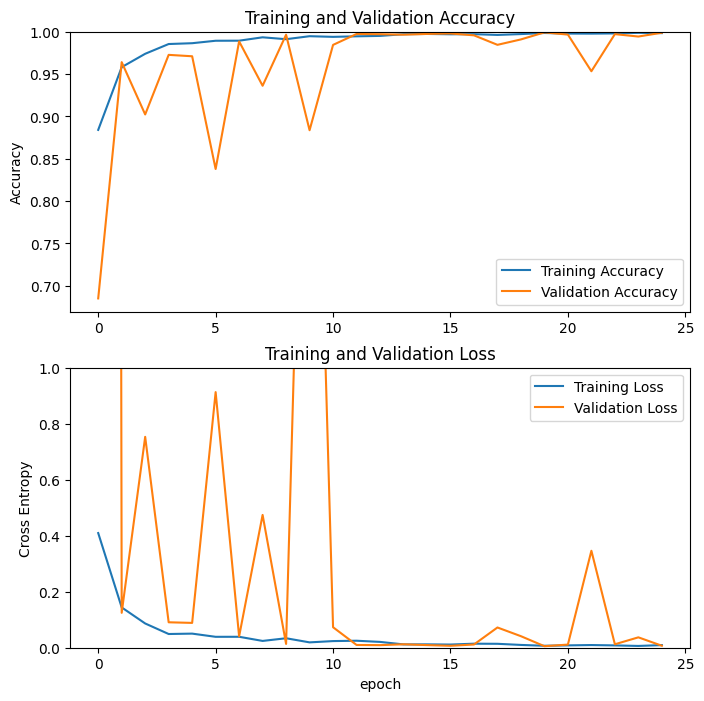

: 

In [19]:
#plot history to see learning curve - just transfer learning
plot(history)

# **Fine-tuning**

In [19]:
def fine_tune(model):
    for layer in model.layers[170:]:
            if not isinstance(layer, layers.BatchNormalization):
                layer.trainable = True
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(optimizer=optimizer, loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=["accuracy"])
    return model


In [20]:
model = fine_tune(l_model)
epochs = 20  # @param {type: "slider", min:8, max:50}
hist = model.fit(train_ds, epochs=epochs, validation_data=val_ds, verbose=1)

Epoch 1/20


2023-04-25 06:28:19.551390: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [50645]
	 [[{{node Placeholder/_4}}]]
2023-04-25 06:28:19.551640: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [50645]
	 [[{{node Placeholder/_4}}]]
2023-04-25 06:28:28.261180: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x369a8c10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-04-25 06:28:28.261200: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce R

1583/1583 [==============================] - ETA: 0s - loss: 4.0012e-04 - accuracy: 1.0000

2023-04-25 06:33:31.167486: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [12661]
	 [[{{node Placeholder/_4}}]]
2023-04-25 06:33:31.167748: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [12661]
	 [[{{node Placeholder/_0}}]]


1583/1583 [==============================] - 342s 200ms/step - loss: 4.0012e-04 - accuracy: 1.0000 - val_loss: 0.0034 - val_accuracy: 0.9993
Epoch 2/20
1583/1583 [==============================] - 317s 200ms/step - loss: 4.1838e-06 - accuracy: 1.0000 - val_loss: 0.0036 - val_accuracy: 0.9992
Epoch 3/20
1583/1583 [==============================] - 317s 200ms/step - loss: 1.2433e-04 - accuracy: 1.0000 - val_loss: 0.0040 - val_accuracy: 0.9992
Epoch 4/20
1583/1583 [==============================] - 317s 200ms/step - loss: 2.0315e-06 - accuracy: 1.0000 - val_loss: 0.0045 - val_accuracy: 0.9992
Epoch 5/20
1583/1583 [==============================] - 317s 200ms/step - loss: 5.6753e-06 - accuracy: 1.0000 - val_loss: 0.0043 - val_accuracy: 0.9995
Epoch 6/20
1583/1583 [==============================] - 317s 200ms/step - loss: 4.0611e-07 - accuracy: 1.0000 - val_loss: 0.0039 - val_accuracy: 0.9995
Epoch 7/20
1583/1583 [==============================] - 317s 200ms/step - loss: 7.6587e-07 - accura

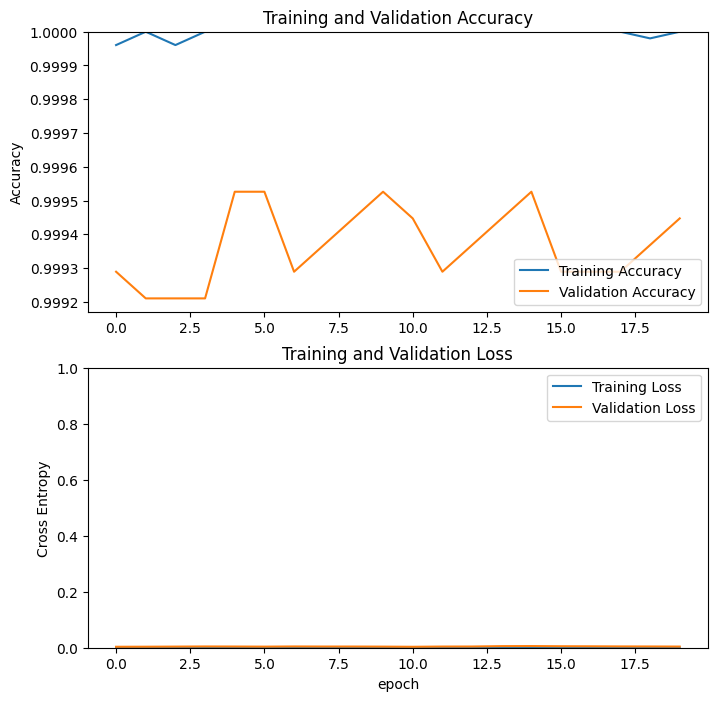

In [21]:
plot(hist)

In [16]:
#code for saving model 
model.save("Models/testmodel-resnet1.1")

INFO:tensorflow:Assets written to: Models/testmodel-resnet1.1/assets


INFO:tensorflow:Assets written to: Models/testmodel-resnet1.1/assets


# **Evaluation and Prediction**

In [17]:
# No need to do this if u just trained the model from above
# load trained model
l_model = tf.keras.models.load_model("Models/testmodel-resnet1.0")
l_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 1024)              102761472 
                                                             

In [18]:
loss, accuracy = model.evaluate(test_ds)
print('Test accuracy :', accuracy)

4/4 [==============================] - 0s 49ms/step - loss: 10.6069 - accuracy: 0.3740
Test accuracy : 0.3739837408065796


In [ ]:
test = preprocess_input(np.array(test_ds))
loss, accuracy = model.evaluate(test)
print("Test accuracy :",accuracy)

## Saving Model 

In [ ]:
#code for saving model 
model.save("/content/drive/My Drive/Models/VGG16-STBv1.3_2")

# **Converting The Model to Lite**

In [ ]:
# Convert the model.
#model = tf.load
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('/content/drive/My Drive/Models/InceptionResNetV2-STBv1.0Lite', 'wb') as f:
  f.write(tflite_model)

# Confusion Matrix

In [ ]:
# Import a function from sklearn to calculate the confusion-matrix.
from sklearn.metrics import confusion_matrix

def print_confusion_matrix(cls_pred):
    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_test,  # True class for test-set.
                          y_pred=cls_pred)  # Predicted class.

    print("Confusion matrix:")
    
    # Print the confusion matrix as text.
    print(cm)
    
    # Print the class-names for easy reference.
    for i, class_name in enumerate(class_names):
        print("({0}) {1}".format(i, class_name))